<a href="https://colab.research.google.com/github/sameepshrestha/segmentation_state_of_the_art/blob/main/pretrained_model_without_skip2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sat Jun 26 05:35:00 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow==2.4.1
import tensorflow
print(tensorflow.__version__)

2.4.1


In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
import cv2 as cv 
from PIL import Image, ImageDraw
import json 
import os 
import glob 
import re 
from tqdm import tqdm
import tensorflow as tf 
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Conv2D, Reshape, Concatenate,MaxPooling2D, AveragePooling2D,Input, BatchNormalization, Activation, UpSampling2D, Concatenate, LeakyReLU,Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D,Multiply,SpatialDropout2D,Add
from tensorflow.keras.optimizers import Adam, SGD
#using tensorflow backend 16 so keras backend still 32bytes so no keras to be used
# from keras.layers.merge import concatenate,Concatenate
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import VGG16
import gc
import psutil

In [ ]:
# model.summary()
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
tf.keras.mixed_precision.experimental.set_policy('mixed_float16')
# # tf.compat.v1.disable_eager_execution()

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Tesla T4, compute capability 7.5


In [ ]:
category = """wall, floor, cabinet, bed, chair, sofa, table, door, window, bookshelf, picture, counter, blinds, desk, shelves, curtain, dresser
, pillow, mirror, floor mat, clothes, ceiling, books, fridge, tv, paper, towel, shower curtain, box, whiteboard, person, nightstand, toilet, sink
, lamp, bathtub, bag"""
category = category.split(r', ')
category = [i.replace('\n','') for i in category]
category_1 = ['background']
for categ in category:category_1.append(categ) 
category_dict = {k:category_1.index(k) for k in category_1}
reverse_map={i:k for k,i in category_dict.items()}
color_list=['gray','red','green','#FFFF00','#8c564b','#4B8BBE','#306998','#FFE873','#FFD43B','#646464','#5a0000','#003a27','#C0C0C0','#808080','#800000','#808000','#00FF00','#00FFFF','#008080','#000080','#FF00FF','#800080','#CD5C5C','#F08080','#FA8072','#E9967A','#FFA07A','#DC143C','#FF7F50','#FFD700','#ffffe0','#bdb76b','#228b22','#B0E0E6','#4169e1','#f0ffff','#d2691e','#BC8F8F']
class_color_map={k:color_list[i] for i,k in enumerate(reverse_map.keys())}

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
Image_width = 640 
Image_height = 480 
no_classes = len(category_dict)
def load_data(path, split=0.2):
    images = sorted(glob.glob(os.path.join(path, "image/*")))
    print(len(images))
    masks = sorted(glob.glob(os.path.join(path, "mask2/*")))
    print(len(masks))
    total_size = 7990
    test_size = 1700
    valid_size=1000
    training_x, test_x = train_test_split(images[:7990], test_size=test_size, random_state=42)
    training_y, test_y = train_test_split(masks[:7990], test_size=test_size, random_state=42)
    train_x, valid_x = train_test_split(training_x, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(training_y, test_size=valid_size, random_state=42)
    return (train_x, train_y), (valid_x, valid_y),(test_x, test_y)
(train_x,train_y),(valid_x,valid_y),(test_x, test_y)=load_data('/content/drive/MyDrive/depth')
train_size=len(train_x)
valid_size=len(valid_x)

def read_image(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_COLOR)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_AREA)
    x = x/255.0
    x=tf.cast(x,dtype=tf.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv.imread(path, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x,(640,480),interpolation=cv.INTER_NEAREST)
  
    x = to_categorical(x,num_classes=no_classes)
    x = x[:,:,:]
    # x = np.expand_dims(x, axis=-1)
    # x=np.concatenate([x,x],axis=-1)
    x=tf.cast(x,dtype=tf.float32)
    return x
# read_mask('/content/drive/MyDrive/depth/mask100/mask1.png')
def parser(x,y):
    def _parse(x,y):
        x=read_image(x)
        y=read_mask(y)
        return x,y
    x,y = tf.numpy_function(_parse, [x,y], [tf.float32,tf.float32])
    x.set_shape([Image_height, Image_width, 3])
    y.set_shape([Image_height, Image_width, no_classes])
    return x,y
    
def tf_dataset(x, y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(parser)
    # dataset = dataset.cache()
    dataset = dataset.repeat()
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(AUTO)
    return dataset
train_dataset=tf_dataset(train_x,train_y,batch=16)
valid_dataset=tf_dataset(valid_x,valid_y,batch=16)
valid_dataset

8033
8033


<PrefetchDataset shapes: ((None, 480, 640, 3), (None, 480, 640, 38)), types: (tf.float32, tf.float32)>

In [ ]:
def decoder_conv_block(inputs,filters1,filters2):
  x = Conv2D(filters1, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
  x = SpatialDropout2D(0.2)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  x = Conv2D(filters2, (3, 3), padding="same",kernel_initializer='he_normal')(x)
  x = SpatialDropout2D(0.2)(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(alpha=0.001)(x)
  return x

def encoder(inputs):
    # skip_add = []
    # skip_multiply = []
    model2 = VGG16(include_top=False,weights="imagenet",input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv3","block4_conv3",'block5_conv3']
    filters = [64,128,256,512,512]
    for filter,name in zip(filters,names):
      print(name)
      x = (model2.get_layer(name).output)
    #   skip_add.append(experiment2(x,filter))
    #   skip_multiply.append(squeeze_excite_block(x))
    output = model2.get_layer('block5_pool').output
    return output

def decoder(x):
#   skip_add.reverse()
#   skip_multiply.reverse()
  num_filters = [64,128, 256,512,512,512]
  num_filters.reverse()
  for i in range(len(num_filters)-1):
    x = decoder_conv_block(x,num_filters[i],num_filters[i+1])
    x = UpSampling2D((2,2))(x)
    # x = Multiply()([x,skip_multiply[i]])
    # x = Add()([x,skip_add[i]])
  return x
def output_block(inputs,classes):
    x = Conv2D(64, (3, 3), padding="same",kernel_initializer='he_normal')(inputs)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.001)(x)
    x = Conv2D(classes,(1, 1), padding="same")(x)
    return x
def main_model(shape):
  inputs = tf.keras.layers.Input(shape)
  encoded = encoder(inputs)
  decoded = decoder(encoded)
  output = output_block(decoded,classes=38)
  model = Model(inputs,output)
  return model
model = main_model((480,640,3))

block1_conv2
block2_conv2
block3_conv3
block4_conv3
block5_conv3


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 480, 640, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 480, 640, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 480, 640, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 240, 320, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 240, 320, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 240, 320, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 120, 160, 128)     0     

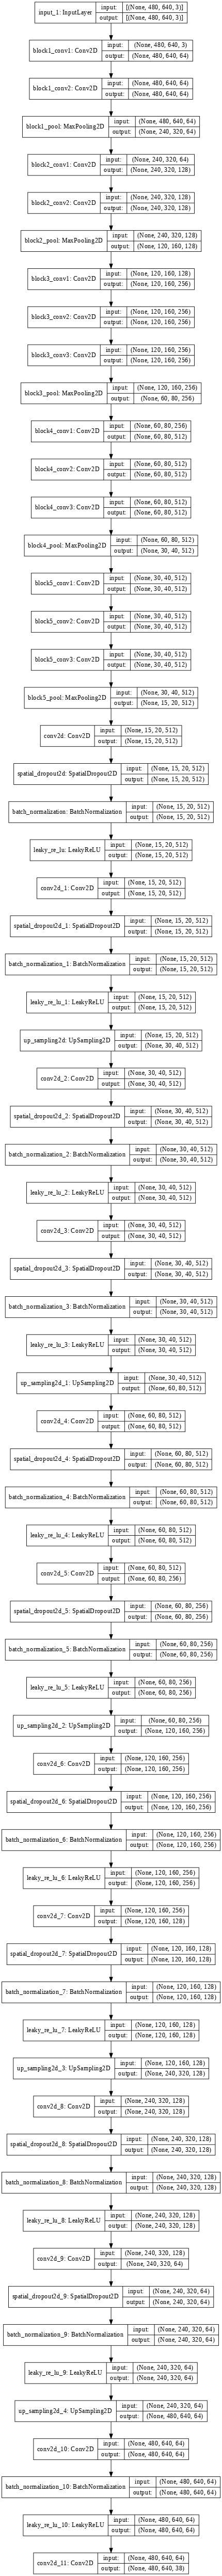

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=64)

In [ ]:
#loss function 

import gc 
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger ,LearningRateScheduler,Callback
class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, schedule):
        super(CustomLearningRateScheduler, self).__init__()
        self.schedule = schedule
    def on_train_batch_begin(self, batch, logs=None):
        if not hasattr(self.model.optimizer, "lr"):
            raise ValueError('Optimizer must have a "lr" attribute.')
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        scheduled_lr = self.schedule(batch, lr)
        tf.keras.backend.set_value(self.model.optimizer.lr, scheduled_lr)
        print("\nbatch %05d: Learning rate is %f." % (batch, scheduled_lr))

def lr_schedule(batch,lr):
    if batch%4==0:
        t_steps = train_size//16
        lr = .0001 *((1- (batch/(t_steps*20)))**.9)
    return lr 

def binary_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred,from_logits=True)
    loss_value = tf.math.reduce_mean(loss,axis=[0])
    return loss_value

def cross_entropy_loss(y_true,y_pred):
    loss = tf.nn.softmax_cross_entropy_with_logits(
    y_true, y_pred, axis=-1, name=None)
    return loss

def custom_metrics(y_true,y_pred,smooth=1):
    y_pred = tf.math.argmax(y_pred, axis=-1)
    # y_pred = tf.expand_dims(y_pred,axis=-1)
    y_pred = tf.one_hot(y_pred,38)
    y_true = y_true[:,:,:,1:38]
    y_pred= y_pred[:,:,:,1:38]
    intersection  = tf.math.reduce_sum((y_true*y_pred),axis = [1,2,3])
    union = (tf.math.reduce_sum(y_true,axis=[1,2,3])+tf.math.reduce_sum(y_pred,axis = [1,2,3])) - intersection
    return tf.math.reduce_mean((intersection+smooth)/(union+smooth),axis=0)
smooth = 1
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)
model=tf.keras.models.load_model('/content/drive/MyDrive/new_architecture/pre-trained-without-skip-june24/',custom_objects={'cross_entropy_loss': cross_entropy_loss ,'dice_coef': dice_coef,'custom_metrics':custom_metrics})
model.compile(loss = cross_entropy_loss,optimizer=Adam(learning_rate =.0005),metrics=[custom_metrics])

In [ ]:
epoch=30
t_steps = train_size//16
v_steps=valid_size//16
val_custom_metrics = .387
for i in range(epoch):
  print('epoch =',i)
  model.fit(train_dataset,epochs= 1,steps_per_epoch=t_steps,callbacks=[CustomLearningRateScheduler(lr_schedule)])
  loss = model.evaluate(valid_dataset,steps=v_steps)
  if loss[1]>=val_custom_metrics:
    val_custom_metrics = loss[1]
    model.save('/content/drive/MyDrive/new_architecture/pre-trained-without-skip-june24/',save_format='tf')
  tf.keras.backend.clear_session()
  gc.collect()

epoch = 0

batch 00000: Learning rate is 0.000100.
  1/330 [..............................] - ETA: 17:53:43 - loss: 1.5264 - custom_metrics: 0.4159
batch 00001: Learning rate is 0.000100.
  2/330 [..............................] - ETA: 11:25 - loss: 1.4702 - custom_metrics: 0.4247   
batch 00002: Learning rate is 0.000100.
  3/330 [..............................] - ETA: 13:15 - loss: 1.4450 - custom_metrics: 0.4352
batch 00003: Learning rate is 0.000100.
  4/330 [..............................] - ETA: 14:16 - loss: 1.4240 - custom_metrics: 0.4438
batch 00004: Learning rate is 0.000099.
  5/330 [..............................] - ETA: 21:30 - loss: 1.4148 - custom_metrics: 0.4462
batch 00005: Learning rate is 0.000099.
  6/330 [..............................] - ETA: 30:30 - loss: 1.4094 - custom_metrics: 0.4477
batch 00006: Learning rate is 0.000099.
  7/330 [..............................] - ETA: 35:36 - loss: 1.4065 - custom_metrics: 0.4483
batch 00007: Learning rate is 0.000099.
  8/3

KeyboardInterrupt: ignored